## Bagging and Boosting on 'titanic' dataset

The ML approaches are not limited to but including the Preprocessing, EDA, feature selection, model selection and evaluation.   

The models used are the Decision Tree, Bagging, Random Forest, AdaBoost, and Gradient Boost.  

The result is that the Gradient Boost gained the best score among the five models. The score means the roc auc score.

#### Summary of Bagging
・ensemble method with weak learners  
・bootstrap sampling  
  (random sampling with replacement)  
・which reduces variance  
・therefore it works well on decision tree 
  which normally has high variance.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

## Preprocessing

In [2]:
df = sns.load_dataset('titanic')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### EDA

In [3]:
# check the data overview
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [4]:
df[df['age'].isna()]         # 177 rows
df[df['embarked'].isna()]    # 2 rows
df[df['deck'].isna()]        # 688 rows
df[df['embark_town'].isna()] # 2 rows
# Too many null in 'deck' columns
df.drop(columns=['deck'], inplace=True)

In [5]:
# a lot of columns are redundant 
# risk of multicollinearity 
df['embark_town'].value_counts()
df['embarked'].value_counts()
# These are too. 
df['survived'].value_counts()
df['alive'].value_counts()
# These as well
df['pclass']
df['class']
# 'Sex', 'who', 'adult_male' could be explained just by 'who'
# as it has categories as "female", "male", "child"
df['sex'].value_counts()
df['who'].value_counts()
df['adult_male'].value_counts()
# childrens' sex are almost half and half: female 43, male 40 
df[df['who']=='child']['sex'].value_counts()
# Thus drop those redundant/dublicated columns.
df.drop(columns=['embark_town', 'alive', 'class', 'sex', 'adult_male'], inplace=True)
# 	全部よけ	adult_male'以外	とsex以外	
# Bagging AUC: 	0.8778	0.8723	0.8727	0.8734
# Random Forest AUC: 	0.8301	0.8556	0.8518	0.8519

In [8]:
# preprocessing 'age' columns
# 'age' columns has a few cells with float numbers such as 0.42, 0.67, ...
df.sort_values(by='age', ascending=True)['age']
# which only make the data complicated.
# Thus replace the age value between (0, 1) to 1
df.loc[(df['age'] > 0) & (df['age'] < 1), 'age'] = 1
# fill the null with median value
median_age = df['age'].median()
df['age'].fillna(median_age, inplace=True)
# change the age column type from float to int
df['age'] = df['age'].astype(int)
# By doing this the Bagging score actually went down

In [9]:
# two nulls in 'embarked' column
# fill them with the most frequent category
mode_embarked = df['embarked'].mode()[0]
df['embarked'].fillna(mode_embarked, inplace=True)

In [10]:
# now all the null and redundant are replaced
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   age       891 non-null    int32  
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
 6   embarked  891 non-null    object 
 7   who       891 non-null    object 
 8   alone     891 non-null    bool   
dtypes: bool(1), float64(1), int32(1), int64(4), object(2)
memory usage: 53.2+ KB


### Label encoding

In [11]:
# set X and y
X = df.drop(['survived'], axis=1)
y = df['survived']
# label encoding
# data type 'object' needs encoding to be handled by pandas
oe = OrdinalEncoder() # categorical variables encoding to numpy.float64
# set output as DataFrame instead of NumpyArray
oe.set_output(transform='pandas') 
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   age       891 non-null    int32  
 2   sibsp     891 non-null    int64  
 3   parch     891 non-null    int64  
 4   fare      891 non-null    float64
 5   embarked  891 non-null    float64
 6   who       891 non-null    float64
 7   alone     891 non-null    float64
dtypes: float64(4), int32(1), int64(3)
memory usage: 52.3 KB


#### Holds-out

In [12]:
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Bagging

In [16]:
# fit and predict
clf = BaggingClassifier(random_state=0, n_estimators=1200)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

# evaluate
print(f"Bagging AUC: {roc_auc_score(y_test, y_pred[:, 1])}")

Bagging AUC: 0.8836607142857145


In [14]:
# Let's check accuracy of single tree
single_tree = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
y_pred_tree = single_tree.predict_proba(X_test)
print(f"Single tree AUC: {roc_auc_score(y_test, y_pred_tree[:, 1])}")

Single tree AUC: 0.763452380952381


In [ ]:
# list of weak learners
# clf.estimators_

## Random Forest

#### Summary of Random Forest
・Ensemble method  
・Bagging + random sampling features  
・Data: Bootstrap sampling  
・Features: Randomly selected sqrt(n) features  
・Thus trees are slightly different from one another  

In [20]:
rf = RandomForestClassifier(n_estimators=1200, max_depth=1, random_state=0, bootstrap=True).fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)
print(f"Random Forest AUC: {roc_auc_score(y_test, y_pred_rf[:, 1])}")

Random Forest AUC: 0.8289285714285715


[0.19333333 0.07166667 0.07       0.02416667 0.19666667 0.10166667
 0.2275     0.115     ]


<BarContainer object of 8 artists>

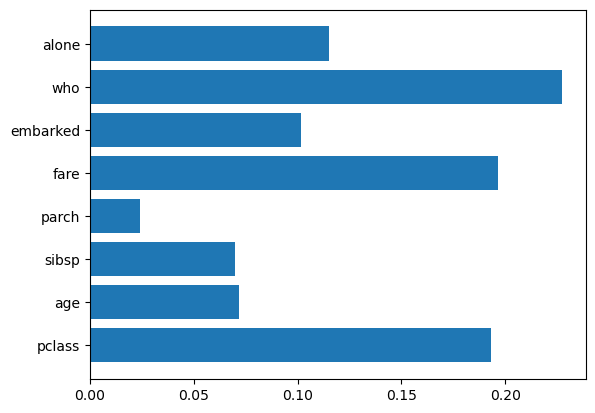

In [18]:
# feature importance
print(rf.feature_importances_)
plt.barh(X.columns, rf.feature_importances_)

[Text(0.5, 0.75, 'x[4] <= 10.817\ngini = 0.475\nsamples = 623\nvalue = [381, 242]'),
 Text(0.25, 0.25, 'gini = 0.345\nsamples = 244\nvalue = [190, 54]'),
 Text(0.75, 0.25, 'gini = 0.5\nsamples = 379\nvalue = [191, 188]')]

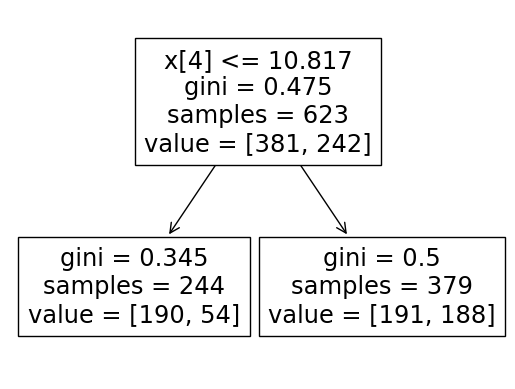

In [22]:
# weak learner tree structure
plot_tree(rf.estimators_[10])

In [23]:
# Since all the features are randomly selected, 
# each tree mostlikely contains different conditions to branch
# such as 'who', 'age', 'pclass', ...
X_test.columns[4]

'fare'

## Boosting: AdaBoost

### Summary of AdaBoost
・unlike Bagging (parallel method), Boosting is series method
・adding more weights on the sample data which were not learned well in a previous round.
・It may reduce both bias and variance.

Adaboost AUC: 0.8823809523809525
[0.15666667 0.24916667 0.14416667 0.0275     0.07666667 0.03916667
 0.30666667 0.        ]


<BarContainer object of 8 artists>

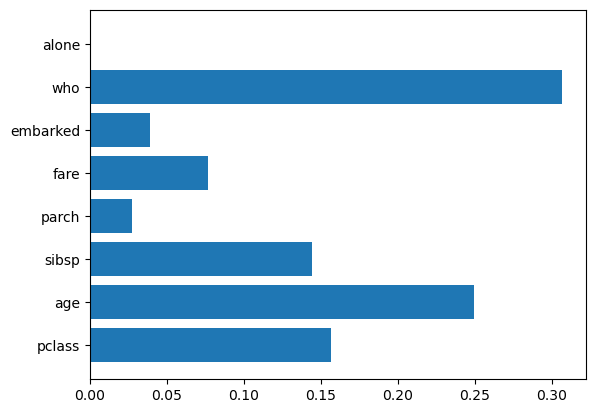

In [24]:
# fit and predict
ada = AdaBoostClassifier(n_estimators=1200, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)
print(f"Adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}")

# feature importance
print(ada.feature_importances_)
plt.barh(X.columns, ada.feature_importances_)

### Gradient Boost

In [25]:
gbc = GradientBoostingClassifier(n_estimators=1200, learning_rate=0.03, max_depth=1, random_state=0).fit(X_test, y_test)
#gbc.predict_proba(X_test)
print(f"GradientBoost auc: {roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])}")

GradientBoost auc: 0.9089285714285714


<BarContainer object of 8 artists>

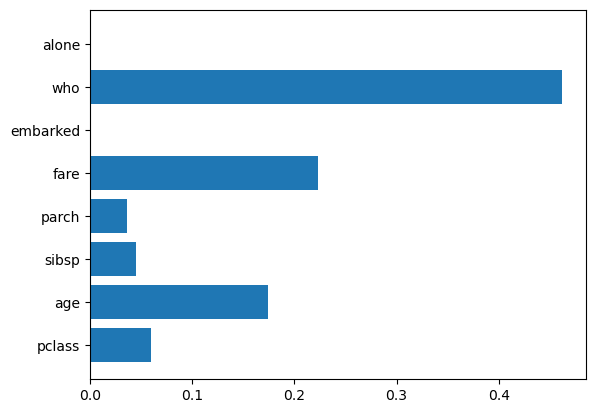

In [26]:
# feature importance
# print(ada.feature_importances_)
plt.barh(X.columns, gbc.feature_importances_)

#### Discussion and Conclusion

We have seen the different models, namely the decision tree, bagging, random forest, adaboost, and gradient boost. 
The final roc-auc-score for each models are;  
  
・gradient boost: 0.908  
・bagging:        0.884  
・adaboost:       0.882  
・random forest:  0.836   
・decision tree:  0.763  
  
Except the decision tree, the random forest was the worst among bagging and boosting methods. However, by changing the feature selection, random forest could have done better performance. For example, if I did not drop these columns below, the random forest did score better by about 2 points.  

df.drop(columns=['embark_town', 'alive', 'class', 'sex', 'adult_male'], inplace=True)
  
Take aways:  
・The feature selection is a key to improve the score.  
・The EDA is a key to be successful on a feature selection. More the EDA works, better understanding the data thus more ideas for preprocessing to improve the model performance.  
  
Ways to improve:  
・Number of iterators, learning rate, and max_depth are not handled much this time. Though by increasing n_iterators, the Boosting and the random forest performance rapidly improve further. At a same time, the time cost increases as well. In future cases, they could be investigated with grid-search, which indeed would be costly but could work fine for this size of data.